/tmp/ipykernel_87104/2099102856.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cluster[col].fillna(median_val, inplace=True)
/tmp/ipykernel_87104/2099102856.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

Cluster counts:
Cluster
3    4304
1    4169
2    3059
0    2382
Name: count, dtype: int64

Cluster Means:
         C Government  C Political parties  C Courts  C Police  \
Cluster                                                          
0            2.514274             2.925273  2.405122  2.257767   
1            1.822979             2.437035  1.815064  1.733509   
2            3.440340             3.473684  3.155280  3.156587   
3            3.244424             3.207249  2.084340  1.914266   

         C Armed forces  Importance of democracy  Highest educational level  \
Cluster                                                                       
0              1.939547                 6.325777                   4.035264   
1              1.683377                 9.275846                   4.882466   
2              2.741419                 8.263812                   4.669173   
3              1.877788                 9.520911                   4.776952   

         Scale of inco

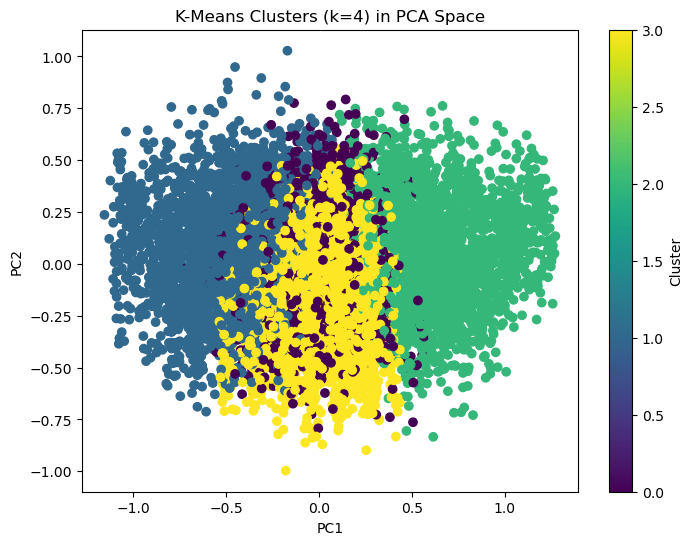

In [10]:
import pandas as pd
import numpy as np

# For clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# For dimensionality reduction or analysis (optional)
from sklearn.decomposition import PCA

# -----------------------------------------------------------------------------
# 1) Load Data
# -----------------------------------------------------------------------------
wave7_csv = "data/preprocessed/filtered_wave_7.csv"
df = pd.read_csv(wave7_csv, low_memory=True)

# -----------------------------------------------------------------------------
# 2) Filter for G8 Countries
#    G8 numeric codes (ISO 3166-1): 
#    840 (USA), 124 (Canada), 250 (France), 276 (Germany), 
#    380 (Italy), 392 (Japan), 643 (Russia), 826 (Great Britain)
# -----------------------------------------------------------------------------
g8_countries = [840, 124, 250, 276, 380, 392, 643, 826]
df_g8 = df[df["Country"].isin(g8_countries)].copy()

# -----------------------------------------------------------------------------
# 3) Replace coded missing values with NaN
# -----------------------------------------------------------------------------
missing_values = [-1, -2, -4, -5]
df_g8.replace(missing_values, np.nan, inplace=True)

# -----------------------------------------------------------------------------
# 4) Select Variables of Interest
#    For clustering, we might combine trust in institutions + 
#    some demographic/attitudinal features.
# -----------------------------------------------------------------------------
confidence_cols = [
    "C Government",         # Confidence in government
    "C Political parties",
    "C Courts",
    "C Police",
    "C Armed forces",
]
other_factors = [
    "Importance of democracy",
    "Highest educational level",
    "Scale of incomes",
    "Age",
]

# Combine the columns we want to cluster on:
selected_cols = confidence_cols + other_factors

# Create a working DataFrame
df_cluster = df_g8[selected_cols].copy()

# -----------------------------------------------------------------------------
# 5) Handle Missing Values
# -----------------------------------------------------------------------------
# Example: fill numeric columns with median,
# but you could also drop rows with excessive missing, or do more advanced imputation.
num_cols = [
    "C Government", "C Political parties", "C Courts", "C Police", "C Armed forces",
    "Importance of democracy", "Scale of incomes", "Age"
]
cat_cols = ["Highest educational level"]  # If you want it as categorical

# 5A. Impute numeric columns with median
for col in num_cols:
    median_val = df_cluster[col].median()
    df_cluster[col].fillna(median_val, inplace=True)

# 5B. Impute categorical columns (mode)
for col in cat_cols:
    mode_val = df_cluster[col].mode(dropna=True)
    if not mode_val.empty:
        df_cluster[col].fillna(mode_val[0], inplace=True)

# -----------------------------------------------------------------------------
# 6) Encode Categorical
# -----------------------------------------------------------------------------
# "Highest educational level" can be treated as ordinal or we might do label encoding.
encoder = LabelEncoder()
df_cluster["Highest educational level"] = encoder.fit_transform(
    df_cluster["Highest educational level"].astype(str)
)

# -----------------------------------------------------------------------------
# 7) Scale All Columns for Clustering
#    (K-means is sensitive to scale, so we typically want everything on [0,1] or standardized)
# -----------------------------------------------------------------------------
scaler = MinMaxScaler()
df_cluster_scaled = pd.DataFrame(
    scaler.fit_transform(df_cluster),
    columns=df_cluster.columns
)

# -----------------------------------------------------------------------------
# 8) Apply K-Means Clustering
#    Let's choose k=3 (or pick k=4, 5... you can experiment).
# -----------------------------------------------------------------------------
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df_cluster_scaled)

# 8A. Get cluster labels
cluster_labels = kmeans.labels_

# Add the cluster labels to the original DataFrame for interpretation
df_cluster["Cluster"] = cluster_labels

# -----------------------------------------------------------------------------
# 9) Analyze Clusters
# -----------------------------------------------------------------------------
# Let's see how many respondents fall into each cluster
print("Cluster counts:")
print(df_cluster["Cluster"].value_counts())

# Let's check the mean values of each feature per cluster
cluster_means = df_cluster.groupby("Cluster")[selected_cols].mean()
print("\nCluster Means:")
print(cluster_means)

# Optionally, re-scale cluster means for interpretability:
# (since we had a scaled version, we can look at df_cluster_scaled instead)
df_cluster_scaled["Cluster"] = cluster_labels
scaled_means = df_cluster_scaled.groupby("Cluster").mean()
print("\nScaled Cluster Means:")
print(scaled_means[selected_cols])

# -----------------------------------------------------------------------------
# 10) (Optional) Dimensionality Reduction for Visualization
#    We can do a quick PCA to visualize cluster separation in 2D
# -----------------------------------------------------------------------------
pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(df_cluster_scaled.drop("Cluster", axis=1))

df_cluster_scaled["PC1"] = pca_coords[:, 0]
df_cluster_scaled["PC2"] = pca_coords[:, 1]

# Example text-based cluster scatter approximation
# (For a real plot, you'd use matplotlib or seaborn)
# e.g., a minimal textual approach:
print("\nPCA explained variance ratio:", pca.explained_variance_ratio_)

# If you want a quick matplotlib plot:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(
    df_cluster_scaled["PC1"],
    df_cluster_scaled["PC2"],
    c=df_cluster_scaled["Cluster"],
    cmap="viridis"
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("K-Means Clusters (k=4) in PCA Space")
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()

# -----------------------------------------------------------------------------
# Interpretation:
# 1) The cluster means show how each group differs (e.g., Cluster 0 might have high Age, 
#    high Confidence in Government, etc.).
# 2) The PCA scatter helps see if there's a clean separation or overlap among clusters.
# -----------------------------------------------------------------------------


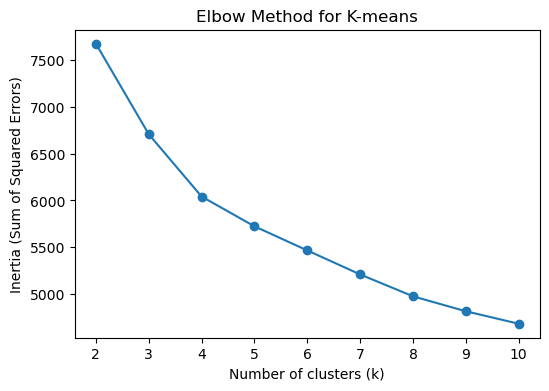

In [11]:
# Elbow Method for K-means
# 
# import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# df_cluster_scaled is your scaled DataFrame (without the cluster labels)
X = df_cluster_scaled.drop("Cluster", axis=1, errors="ignore")  # If you have "Cluster" col

inertias = []
k_values = range(2, 11)  # e.g., from 2 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker="o")
plt.xticks(k_values)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Sum of Squared Errors)")
plt.title("Elbow Method for K-means")
plt.show()


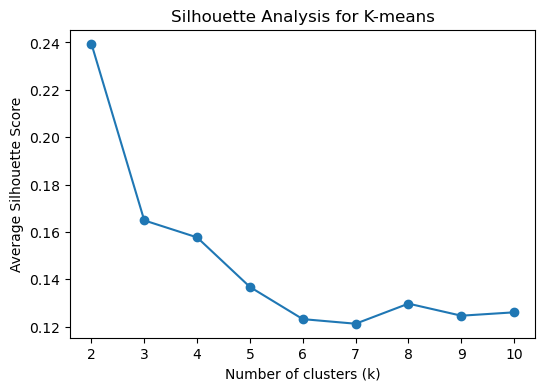

k=2, silhouette=0.239
k=3, silhouette=0.165
k=4, silhouette=0.158
k=5, silhouette=0.137
k=6, silhouette=0.123
k=7, silhouette=0.121
k=8, silhouette=0.130
k=9, silhouette=0.125
k=10, silhouette=0.126


In [12]:
# Shillouette Analysis for K-means

from sklearn.metrics import silhouette_score

sil_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    score = silhouette_score(X, labels)
    sil_scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(k_values, sil_scores, marker="o")
plt.xticks(k_values)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Analysis for K-means")
plt.show()

# Print out the silhouette scores for each k
for k, s in zip(k_values, sil_scores):
    print(f"k={k}, silhouette={s:.3f}")
